In [113]:
import os, sys
from os import listdir
from os.path import isfile, isdir, join
import math
import numpy as np
import pandas as pd
import cv2, imutils
from PIL import Image
import json, collections
import pickle as pkl
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import time, shutil
import argparse, pathlib

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial.transform import Rotation as R
# import pywavefront
import pyrender, trimesh
from trimesh import Trimesh
from trimesh.visual import texture, TextureVisuals
from scipy.ndimage import gaussian_filter

In [114]:
import torch as torch
import sys 
import cv2
import numpy as np
import pickle as pkl
from scipy.stats import norm, gamma
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from Geometry_Util import rotation_angles_frome_positions, rotation_axis_angle_from_vector, directions_from_rotation_angles

In [3]:
%load_ext autoreload
%autoreload 1

%aimport Signal_processing_utils
%aimport Geometry_Util

# Input Block

### For Royal With Cheese

In [4]:
# initial angle 
starting_angle = [100, 0]
# final bias
x_bias = -30 # left right
y_bias = -10 # up down
# input video
input_video_path = "F:/MASC/JALI_gaze/animations/eval_royal_with_cheese/pulp_fiction_1.mp4"
output_path = "F:/MASC/JALI_gaze/animations/eval_royal_with_cheese/non_conversational_output/pulp_fiction_1.pkl"
# models
model_path = "C:/Users/evansamaa/Documents/GitHub/saliency-driven-gaze/Unreal Project/SaccadicModel/msinet_scripted_256.pt"
bias_map_path = "C:/Users/evansamaa/Documents/GitHub/saliency-driven-gaze/Unreal Project/SaccadicModel/saccadic_bias.png"

### For Office scene

In [128]:
# initial angle 
starting_angle = [0, 0]
# final bias
x_bias = 0 # left right
y_bias = 0 # up down
# input video
input_video_path = "F:/MASC/JALI_gaze/animations/eval_office_360/office_stanford.mov"
output_path = "F:/MASC/JALI_gaze/animations/eval_office_360/non_conversational_output/office_stanford.pkl"
# models
model_path = "C:/Users/evansamaa/Documents/GitHub/saliency-driven-gaze/Unreal Project/SaccadicModel/msinet_scripted_256.pt"
bias_map_path = "C:/Users/evansamaa/Documents/GitHub/saliency-driven-gaze/Unreal Project/SaccadicModel/saccadic_bias.png"

In [118]:
SEED = 2334
np.random.seed(SEED)
plt.ion()

def get_timestamp(ts):
    td = timedelta(seconds=ts)
    dt = datetime.strptime("00:00:00", "%H:%M:%S") + td
    return dt.strftime("%H:%M:%S.%f")

def get_framenum(ts, fps):
    dt = datetime.strptime(ts, "%H:%M:%S.%f")
    td = dt-datetime.strptime("00:00:00.000000", "%H:%M:%S.%f")
    return int(td.total_seconds()*fps)


def get_texture(my_uvs, img_array):
    uvs = my_uvs
    img = Image.fromarray(img_array[..., ::-1])
    texture = pyrender.Texture(source=img, source_channels='RGB')
    material = pyrender.MetallicRoughnessMaterial(baseColorTexture=texture, doubleSided=True)
    return texture, material

In [119]:
class Salience_map_model:
    def __init__(self) -> None:
        self._module  = torch.jit.load(model_path, torch.device("cpu"))
    def get_fixation(self, image, bias_map, inhibition_map, salient_weight):
        uv_coordinates = [0, 0]
        # Create cv::Mat from raw input image
        cv_image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB).astype(np.float32) / 255.0
        # cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
        # Show the image in the window
        # cv2.imshow("Image", cv_image)
        input_tensor = torch.from_numpy(cv_image)
        input_tensor = input_tensor.permute((2, 0, 1)).contiguous().unsqueeze(0)

        # Normalize channels
        input_tensor[:, 0, :, :] = (input_tensor[:, 0, :, :] - 0.485) / 0.229
        input_tensor[:, 1, :, :] = (input_tensor[:, 1, :, :] - 0.456) / 0.224
        input_tensor[:, 2, :, :] = (input_tensor[:, 2, :, :] - 0.406) / 0.225
        input_tensor = input_tensor.to(torch.device('cpu'))

        # Pass Data Through Neural Net to Get Output
        result = self._module.forward(input_tensor).to('cpu')
        salmap_tensor = result.squeeze(0).detach()

        # Saliency tensor normalization
        salmap_tensor -= torch.min(salmap_tensor)
        salmap_tensor /= (1e-7 + torch.max(salmap_tensor))

        # Convert to cv::Mat
        salmap_tensor = salmap_tensor.permute((1, 2, 0)).to('cpu')
        cv_salmap = salmap_tensor.numpy()
        raw_cv_sal_map = cv_salmap
        # Apply salient weight
        cv_salmap = (cv_salmap * salient_weight) + (1.0 - salient_weight)

        # Get bias map
        # cv_bias = np.array(bias_map[:, :, 0], dtype=np.float32) / 255.0
        cv_bias = bias_map / 255.0
        
        # Saliency map to probability distribution
        sum_salmap = np.sum(cv_salmap)
        sum_bias = np.sum(cv_bias)
        if(inhibition_map.sum() == 0):
            weighted_inhibition_map = 1
        else:
            # inhibition_map = inhibition_map / inhibition_map.sum()
            weighted_inhibition_map = (1 - inhibition_map) * 0.9 + (1-0.9)

        # Normalize distributions
        cv_salmap /= sum_salmap
        # cv_bias /= sum_bias
        cv_bias = 0.9 * cv_bias + 0.1
        # weighted_inhibition_map = 1
        # cv_bias = 1
        # Create the fixation probability map
        fixation_proba = cv_bias * cv_salmap[:, :, 0] * weighted_inhibition_map

        # Initialize the random generator for sampling
        np.random.seed()
        gen = np.random.default_rng()

        # Cast the Mat into a float vector
        fix_proba = fixation_proba.flatten()
        fix_proba /= fix_proba.sum()
        # Creates the distribution
        # Sample N pixels in the 256*256 vector
        nb_samples = 10
        samples = np.random.choice(len(fix_proba), size=nb_samples, p=fix_proba)
        probas = fix_proba[samples]
        # Keep the max proba
        maxProbaIndex = np.argmax(probas)
        fix_sample = samples[maxProbaIndex]

        # Height
        uv_coordinates[0] = fix_sample % image.shape[0]
        # Width
        uv_coordinates[1] = int(fix_sample / image.shape[1])

        return uv_coordinates, fixation_proba

# Testing

unable to load materials from: VRSphereUV.mtl


(8249, 3)
(8249, 2)
(15872, 3)
(15872, 3)


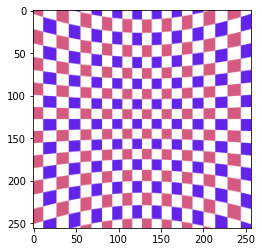

In [120]:
mesh_resolver = trimesh.resolvers.FilePathResolver('./')
mesh = trimesh.load('./VR_evaluationnn/VRSphereUV.obj', resolver=mesh_resolver, maintain_order=False)
texture_img = cv2.imread('./VR_evaluationnn/pattern_checkerboard_1_2_0-0_0_1__ffffff_805ad5_e91e63 (1).png', cv2.IMREAD_COLOR)
# wavefront_obj = pywavefront.Wavefront('./VRSphereUV.obj')
# raw_uvs = np.array(wavefront_obj.materials['Material.001'].vertices).reshape(-1, 2)
raw_uvs = mesh.visual.uv
raw_uvs[:, 0] = 1-raw_uvs[:, 0]
print(mesh.vertices.shape)
print(raw_uvs.shape)
print(mesh.faces.shape)
print(mesh.face_normals.shape)

pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=texture_img)
pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)
offscreen_renderer = pyrender.OffscreenRenderer(viewport_width=256, 
                                                viewport_height=256,
                                                point_size=1.0)
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[255, 255, 255])
camera = pyrender.camera.PerspectiveCamera(np.deg2rad(70), znear=0.05, zfar=None, aspectRatio=1.)
pymesh_node = scene.add(pymesh)
ssc = -scene.scale

rotation = R.from_euler('xyz', [0, -90, 0], degrees=True)
rot_mat = rotation.as_matrix()
scale_mat = np.identity(3)
rot_mat = np.matmul(scale_mat, rot_mat)
cam_pose = np.identity(4)
cam_pose[:3, :3] = rot_mat
# cam_pose[:3, 3] = np.array([0, 0, 10])

camera_node = scene.add(camera, pose=cam_pose)
color, depth = offscreen_renderer.render(scene)
render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
# cv2.imshow('RENDER', render)
# cv2.waitKey(0)
plt.imshow(render)
plt.show()

# Load models and inputs videos

In [121]:
 
image = cv2.imread(bias_map_path)
T_h_sampler = norm(0.15, 0.1)
X_h_sampler = norm(40, 5)
Y_h_sampler = norm(15, 2)
fixation_duration_sampler = gamma(1.2394, 0.1880)
# T_h =  T_h_sampler.rvs(1)
# fixation_time = fixation_duration_sampler.rvs(1) + 0.08


# Animation System Test

## Animation Model Test

In [9]:
def mock_fixation_model(ts, arr):
    # ts = np.arange(0, arr.shape[0]) / fps
    arr_interp = interp1d(ts, arr, axis=0, kind="previous")
    def mock_fixation_point_grabber(t):
        return arr_interp(t)
    return mock_fixation_point_grabber

In [10]:
# video metadata
fps = 24.0
dt = 1/fps
inhibition_tracking = []
test_points = np.load("F:/MASC/JALI_gaze/for_non_conversational/debugging/test_look_at_points.npy")
# here is where I got the salient points
get_pt = mock_fixation_model(test_points[:, 0], test_points[:, 1:])
# ts = np.arange(0, test_points[-1, 0] * fps) / fps

# simulation variables
counter = 0
next_gaze_shift = 0 # track the time for the next gaze shift ()
next_head_shift = 0 # track the time for the next gaze shift ()
current_gaze_target = np.array([0, 0])
current_gaze_pos = np.array([0, 0])
current_gaze_vel = np.array([0, 0])
current_head_target = np.array([0, 0]) 
current_head_vel = np.array([0, 0])
current_head_pos = np.array([0, 0])


gaze_start = False
head_start = False
# track outputs
gaze_points = [np.expand_dims(current_gaze_pos, axis=0)]
head_points = [np.expand_dims(current_head_pos, axis=0)]
# Loop through all frames in the video
vel = []
for counter in range(0, len(ts)):
    t = counter * dt
    # =========== For gaze shift =========== 
    fixation_point = rotation_angles_frome_positions(get_pt(t))
    if np.linalg.norm(fixation_point - current_gaze_target) >= 0.001:
    # if t > next_gaze_shift:
        # ========================= swap real saccadic model with get_pt(t) =========================
        fixation_point = rotation_angles_frome_positions(get_pt(t))
        # ========================= swap real saccadic model with get_pt(t) =========================
        # define the new gaze target
        current_gaze_target = fixation_point
        # find the next time gaze shift should happen 
        next_gaze_shift = t + fixation_duration_sampler.rvs(1)[0] + 0.08
        next_head_shift = t + T_h_sampler.rvs(1)[0]
        gaze_start = True
    # =========== For head rotation =========== 
    # find the angle between the current head angle and the gaze target
    head_vec = directions_from_rotation_angles(np.expand_dims(current_head_pos, axis=0), 1)[0]
    gaze_target = directions_from_rotation_angles(np.expand_dims(current_gaze_target, axis=0), 1)[0]
    H_angle_length = np.linalg.norm(head_vec - gaze_target)
    H_angle = np.arccos(0.5*((H_angle_length)**2) - 1) / np.pi * 180
    H_angle = np.linalg.norm(current_head_pos - current_gaze_target)
    print(t, next_head_shift, H_angle)
    if t > next_head_shift:
        # update a new head target when H_angle is sufficiently large
        X_h = X_h_sampler.rvs(1)[0]
        if H_angle > X_h:
            head_start = True
            current_head_target = current_gaze_target
            # update this so this won't get updated
            next_head_shift = next_head_shift + 10000
    Y_h = Y_h_sampler.rvs(1)[0]
    if H_angle <= Y_h:
        head_start = False
    if gaze_start and np.linalg.norm(current_gaze_target - current_head_pos) > 0.001:
        # move gaze
        current_gaze_vel = current_gaze_target - current_gaze_pos
        if np.linalg.norm(current_gaze_vel) > 0:
            current_gaze_vel = current_gaze_vel / np.linalg.norm(current_gaze_vel) * 100
    else:
        current_gaze_vel = np.zeros([2])
        gaze_start = False
    if head_start:
        # compute acceleration vector
        current_head_accel = current_head_target - current_head_pos
        # normalize the acceleration will be 30 deg/s^2
        if np.linalg.norm(current_head_accel) > 0:
            current_head_accel = current_head_accel / np.linalg.norm(current_head_accel) * 30
        # compute head velocity based on acceleration
        current_head_vel = current_head_vel + current_head_accel * dt
        # velocity is normalized to be less than 40 deg/s
        head_vel_norm = np.linalg.norm(current_head_vel)
        clipped_head_vel_norm = np.minimum(head_vel_norm, 40)
        current_head_vel = current_head_vel / head_vel_norm * clipped_head_vel_norm
    else:
        # head will decelerate in the negative direction of the velocity
        head_decelleration = (-current_head_vel)
        # the deceleration is also 30 deg/s
        if np.linalg.norm(head_decelleration) > 0:
            head_decelleration = head_decelleration / np.linalg.norm(head_decelleration) * 30
        # compute new velocity
        new_head_vel = current_head_vel + head_decelleration * dt
        if np.dot(new_head_vel, current_head_vel) < 0:
            current_head_vel = 0
        else:
            current_head_vel = new_head_vel
    new_gaze_pos = current_gaze_pos + current_gaze_vel * dt
    new_head_pos = current_head_pos + current_head_vel * dt
    # make sure the gaze do not over shoot
    if np.dot(current_gaze_target - new_gaze_pos, current_gaze_target - current_gaze_pos) < 0:
        gaze_start = False
        current_gaze_pos = current_gaze_target
    else:
        current_gaze_pos = new_gaze_pos
    # make sure head rotation do not over shoot
    
    if np.dot(current_head_target - new_head_pos, current_head_target - current_head_pos) < 0:
        head_start = False
        current_head_pos = current_head_target
    else:
        current_head_pos = new_head_pos
    # print(np.linalg.norm(current_gaze_vel))
    gaze_points.append(np.expand_dims(current_gaze_pos, axis=0))
    head_points.append(np.expand_dims(current_head_pos, axis=0))
    

0.0 -0.015833449276051514 60.7326359624714
0.041666666666666664 9999.984166550725 60.68055262913806
0.08333333333333333 9999.984166550725 60.57638596247139
0.125 9999.984166550725 60.4201359624714
0.16666666666666666 9999.984166550725 60.21180262913806
0.20833333333333331 9999.984166550725 59.9513859624714
0.25 9999.984166550725 59.6388859624714
0.29166666666666663 9999.984166550725 59.27430262913806
0.3333333333333333 9999.984166550725 58.857635962471406
0.375 9999.984166550725 58.3888859624714
0.41666666666666663 9999.984166550725 57.86805262913806
0.4583333333333333 9999.984166550725 57.29513596247139
0.5 9999.984166550725 56.6701359624714
0.5416666666666666 9999.984166550725 55.993052629138056
0.5833333333333333 9999.984166550725 55.26388596247139
0.625 9999.984166550725 54.48263596247139
0.6666666666666666 9999.984166550725 53.64930262913806
0.7083333333333333 9999.984166550725 52.76388596247139
0.75 9999.984166550725 51.82638596247139
0.7916666666666666 9999.984166550725 50.83680

## Output the Result of the animation model

In [11]:
gaze_points_arr = np.concatenate(gaze_points, axis=0)
head_points_arr = np.concatenate(head_points, axis=0)
gaze_pos_arr = directions_from_rotation_angles(gaze_points_arr, 100)
ek = []
hk = []
ts_list = ts.tolist()
for i in range(0, ts.shape[0]):
    ek.append([ts_list[i], float(gaze_pos_arr[i, 0]), float(gaze_pos_arr[i, 1]), float(gaze_pos_arr[i, 2])])
    hk.append([ts_list[i], float(head_points_arr[i, 0]), float(head_points_arr[i, 1])])
out = {"eye_frames": [ek],
        "head_frames": [hk],
        "micro_saccade": [],
        "other_neck": [[],[],[],[],[],[]],
        "envelope":[]}
with open(output_path, 'wb') as f:
    pkl.dump(out, f, protocol=2)
print(output_path)

F:/MASC/JALI_gaze/animations/eval_royal_with_cheese/non_conversational_output/pulp_fiction_1.pkl


# System Test

In [122]:
def mock_UV_traversal(angle, image):
    # here I;m 
    w, h, c = image.shape 
    center_pixel = [int(w/2), int(h/2)] 

In [123]:
bias_map = cv2.imread(bias_map_path,  cv2.IMREAD_GRAYSCALE)

In [124]:
print(starting_angle)

[0, 0]


In [125]:
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[255, 255, 255])
camera = pyrender.camera.PerspectiveCamera(np.deg2rad(70), znear=0.05, zfar=None, aspectRatio=1.)
sal = Salience_map_model()
exit_flag = False
fixed_height = 512
camera_offsets = (0, 0, 0)
# comment out when using actual gaze
gaze_df = np.zeros((1, 2), dtype=np.float32)

gaze_df[:, 0] = 0 # 0 is x (up down)
gaze_df[:, 1] = 0 # 1 is y (left right)
vid_path = input_video_path
cap = cv2.VideoCapture(vid_path)
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# make the output datastructure
assert (gaze_df.ndim==2)
if gaze_df.shape[0]>=frame_count:
    gaze_df = gaze_df[:frame_count, ...]
else:
    gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

 # set the first look-at-point
gaze_df[0, 0] = starting_angle[0]
gaze_df[0, 1] = starting_angle[1]

# set up simulation variables:
dt = 1/fps # time stamp
inhibition_map = np.zeros([height, width, 1])
d_inhibition_map = np.zeros([height, width, 1])
counter = 0
next_gaze_shift = 0 # track the time for the next gaze shift ()
next_head_shift = 0 # track the time for the next gaze shift ()
starting_angle = np.array(starting_angle)
current_gaze_target = starting_angle.copy()

for frame_num in tqdm(range(frame_count)):
    counter = frame_num # XD
    t = counter * dt
    ret, frame = cap.read()
    if not ret:
        break
    inhibition_map += d_inhibition_map * dt
    d_inhibition_map = np.where(inhibition_map < 0, 0, d_inhibition_map)
    inhibition_map = np.maximum(inhibition_map, 0)
    if t > next_gaze_shift:
        # update inhibition_map
        # ========================= render POV of scene =========================
        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=1000, inter=cv2.INTER_LANCZOS4)
        pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=frame_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)
        # get the rotation. 
        prev_fixation_point = [-current_gaze_target[1], current_gaze_target[0]]
        # compute the POV frame
        rotation = R.from_euler('xyz', [prev_fixation_point[0], -90-prev_fixation_point[1], 0], degrees=True)
        rot_mat = rotation.as_matrix()
        scale_mat = np.identity(3)
        rot_mat = np.matmul(scale_mat, rot_mat)
        cam_pose = np.identity(4)
        cam_pose[:3, :3] = rot_mat
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        color, depth = offscreen_renderer.render(scene)
        render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
        disp_frame = render.copy()
        # ==== get inhibition map render ====
        inhibition_map_RGB = cv2.cvtColor((np.minimum(inhibition_map, 1) * 255.0).astype('uint8'),cv2.COLOR_GRAY2RGB)
        inhibition_map_resized = (imutils.resize(inhibition_map_RGB, height=1000, inter=cv2.INTER_CUBIC))
        inhibition_map_pytexture, inhibition_map_pymaterial = get_texture(my_uvs=raw_uvs, img_array=inhibition_map_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=inhibition_map_pymaterial)
        # get the rotation
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        inhibition_map_color, inhibition_map_depth = offscreen_renderer.render(scene)
        inhibition_map_render = cv2.cvtColor(inhibition_map_color,cv2.COLOR_RGB2GRAY)
        disp_inhibition_map = inhibition_map_render.copy()
        # ============= get fixation point ==============
        fixation_point, salience_map = sal.get_fixation(disp_frame, bias_map, inhibition_map_render, 1)
        # plt.scatter([fixation_point[0]], [fixation_point[1]])
        # plt.scatter([50], [150])
        # plt.show()
        delta_horizontal_global = (fixation_point[0] - 128) / 256 * 70 
        delta_vertical_global = (fixation_point[1] - 128) / 256 * 70
        current_gaze_target[0] = current_gaze_target[0] + delta_horizontal_global
        current_gaze_target[1] = current_gaze_target[1] + delta_vertical_global        
        # update inhibition map
        inhibition_map_delta = np.zeros(inhibition_map.shape)
        inhibition_point_index_vertical = current_gaze_target[1] / 180 * height + (height/2)
        inhibition_point_index_horizontal = current_gaze_target[0] / 360 * width + (width/2) 
        inhibition_point_index_vertical = math.floor(inhibition_point_index_vertical)
        inhibition_point_index_horizontal = math.floor(inhibition_point_index_horizontal)
        kernel = np.zeros_like(inhibition_map)
        kernel[inhibition_point_index_vertical, inhibition_point_index_horizontal] = 1
        inhibition_map_delta = gaussian_filter(kernel, sigma=5/360*width, mode='constant')
        inhibition_map_delta /= inhibition_map_delta.max()
        inhibition_map = inhibition_map + inhibition_map_delta
        # find the next time gaze shift should happen 
        gaze_duration = fixation_duration_sampler.rvs(1)[0]
        next_gaze_shift = t + gaze_duration + 0.08
        next_head_shift = t + T_h_sampler.rvs(1)[0]
        gaze_start = True
        d_inhibition_map -= inhibition_map_delta / np.minimum(gaze_duration * 20, (1.42 * 15))
        plt.imshow(render)
        plt.show()
        plt.imshow(salience_map)
        plt.show()
        plt.imshow(inhibition_map_render)
        plt.show()
        
        # make animation:

IndexError: index 0 is out of bounds for axis 0 with size 0

In [129]:
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[255, 255, 255])
camera = pyrender.camera.PerspectiveCamera(np.deg2rad(70), znear=0.05, zfar=None, aspectRatio=1.)

exit_flag = False
fixed_height = 512
camera_offsets = (0, 0, 0)
# comment out when using actual gaze
# gaze_df = np.zeros((1, 2), dtype=np.float32)

# gaze_df[:, 0] = 0 # 0 is x (up down)
# gaze_df[:, 1] = 0 # 1 is y (left right)
vid_path = input_video_path
cap = cv2.VideoCapture(vid_path)
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# # make the output datastructure
# assert (gaze_df.ndim==2)
# if gaze_df.shape[0]>=frame_count:
#     gaze_df = gaze_df[:frame_count, ...]
# else:
#     gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

#  # set the first look-at-point
# gaze_df[0, 0] = starting_angle[0]
# gaze_df[0, 1] = starting_angle[1]

# set up simulation variables:
dt = 1/fps # time stamp
inhibition_map = np.zeros([height, width, 1])
d_inhibition_map = np.zeros([height, width, 1])
counter = 0
next_gaze_shift = 0 # track the time for the next gaze shift ()
next_head_shift = 0 # track the time for the next gaze shift ()
starting_angle = np.array(starting_angle)
current_gaze_target = starting_angle.copy()
current_gaze_pos = starting_angle.copy()
current_gaze_vel = np.array([0, 0])
current_head_target = starting_angle.copy()
current_head_vel = np.array([0, 0])
current_head_pos = starting_angle.copy()
head_points = []
gaze_points = []
sal = Salience_map_model()
for frame_num in tqdm(range(frame_count)):
    counter = frame_num # XD
    t = counter * dt
    ret, frame = cap.read()
    if not ret:
        break
    inhibition_map += d_inhibition_map * dt
    d_inhibition_map = np.where(inhibition_map < 0, 0, d_inhibition_map)
    inhibition_map = np.maximum(inhibition_map, 0)
    if t > next_gaze_shift:
        # update inhibition_map
        # ========================= render POV of scene =========================
        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=1000, inter=cv2.INTER_LANCZOS4)
        pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=frame_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)
        # get the rotation. 
        prev_fixation_point = [-current_gaze_target[1], current_gaze_target[0]]
        # compute the POV frame
        rotation = R.from_euler('xyz', [prev_fixation_point[0], -90-prev_fixation_point[1], 0], degrees=True)
        rot_mat = rotation.as_matrix()
        scale_mat = np.identity(3)
        rot_mat = np.matmul(scale_mat, rot_mat)
        cam_pose = np.identity(4)
        cam_pose[:3, :3] = rot_mat
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        color, depth = offscreen_renderer.render(scene)
        render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
        disp_frame = render.copy()
        # ==== get inhibition map render ====
        inhibition_map_RGB = cv2.cvtColor((np.minimum(inhibition_map, 1) * 255.0).astype('uint8'),cv2.COLOR_GRAY2RGB)
        inhibition_map_resized = (imutils.resize(inhibition_map_RGB, height=1000, inter=cv2.INTER_CUBIC))
        inhibition_map_pytexture, inhibition_map_pymaterial = get_texture(my_uvs=raw_uvs, img_array=inhibition_map_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=inhibition_map_pymaterial)
        # get the rotation
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        inhibition_map_color, inhibition_map_depth = offscreen_renderer.render(scene)
        inhibition_map_render = cv2.cvtColor(inhibition_map_color,cv2.COLOR_RGB2GRAY)
        disp_inhibition_map = inhibition_map_render.copy()
        # ============= get fixation point ==============
        fixation_point, salience_map = sal.get_fixation(disp_frame, bias_map, inhibition_map_render, 1)
        # plt.scatter([fixation_point[0]], [fixation_point[1]])
        # plt.scatter([50], [150])
        # plt.show()
        
        delta_horizontal_global = (fixation_point[0] - 128) / 256 * 70  # this is the delta horizontal in the global angle space (down positive)
        delta_vertical_global = (fixation_point[1] - 128) / 256 * 70    # this is the delta vertical in the global angle space (down positive)
        current_gaze_target[0] = current_gaze_target[0] + delta_horizontal_global # doing addtion between angles that are left positive
        current_gaze_target[1] = current_gaze_target[1] + delta_vertical_global # doing addtion between angles that are down positive
        # update inhibition map
        
        # find the index of the pixal on the global map 
        inhibition_point_index_vertical = current_gaze_target[1] / 180 * height + (height/2)
        inhibition_point_index_horizontal = current_gaze_target[0] / 360 * width + (width/2) 
        inhibition_point_index_vertical = math.floor(inhibition_point_index_vertical)
        inhibition_point_index_horizontal = math.floor(inhibition_point_index_horizontal)
        kernel = np.zeros_like(inhibition_map)
        kernel[inhibition_point_index_vertical, inhibition_point_index_horizontal] = 1
        inhibition_map_delta = gaussian_filter(kernel, sigma=5/360*width, mode='constant')
        inhibition_map_delta /= inhibition_map_delta.max()
        inhibition_map = inhibition_map + inhibition_map_delta
        # find the next time gaze shift should happen 
        gaze_duration = fixation_duration_sampler.rvs(1)[0]
        next_gaze_shift = t + gaze_duration + 0.08
        next_head_shift = t + T_h_sampler.rvs(1)[0]
        gaze_start = True
        d_inhibition_map -= inhibition_map_delta / np.minimum(gaze_duration * 20, (1.42 * 15))
        # plt.imshow(render)
        # plt.show()
        # plt.imshow(inhibition_map_render)
        # plt.show()
        
        # make animation:
         # =========== For head rotation =========== 
    # find the angle between the current head angle and the gaze target
    head_vec = directions_from_rotation_angles(np.expand_dims(current_head_pos, axis=0), 1)[0]
    gaze_target = directions_from_rotation_angles(np.expand_dims(current_gaze_target, axis=0), 1)[0]
    H_angle_length = np.linalg.norm(head_vec - gaze_target)
    H_angle = np.arccos(0.5*((H_angle_length)**2) - 1) / np.pi * 180
    H_angle = np.linalg.norm(current_head_pos - current_gaze_target)
    print(t, next_head_shift, H_angle)
    if t > next_head_shift:
        # update a new head target when H_angle is sufficiently large
        X_h = X_h_sampler.rvs(1)[0]
        if H_angle > X_h:
            head_start = True
            current_head_target = current_gaze_target
            # update this so this won't get updated
            next_head_shift = next_head_shift + 10000
    Y_h = Y_h_sampler.rvs(1)[0]
    if H_angle <= Y_h:
        head_start = False
    if gaze_start and np.linalg.norm(current_gaze_target - current_head_pos) > 0.001:
        # move gaze
        current_gaze_vel = current_gaze_target - current_gaze_pos
        if np.linalg.norm(current_gaze_vel) > 0:
            current_gaze_vel = current_gaze_vel / np.linalg.norm(current_gaze_vel) * 100
    else:
        current_gaze_vel = np.zeros([2])
        gaze_start = False
    if head_start:
        # compute acceleration vector
        current_head_accel = current_head_target - current_head_pos
        # normalize the acceleration will be 30 deg/s^2
        if np.linalg.norm(current_head_accel) > 0:
            current_head_accel = current_head_accel / np.linalg.norm(current_head_accel) * 30
        # compute head velocity based on acceleration
        current_head_vel = current_head_vel + current_head_accel * dt
        # velocity is normalized to be less than 40 deg/s
        head_vel_norm = np.linalg.norm(current_head_vel)
        clipped_head_vel_norm = np.minimum(head_vel_norm, 40)
        current_head_vel = current_head_vel / head_vel_norm * clipped_head_vel_norm
    else:
        # head will decelerate in the negative direction of the velocity
        head_decelleration = (-current_head_vel)
        # the deceleration is also 30 deg/s
        if np.linalg.norm(head_decelleration) > 0:
            head_decelleration = head_decelleration / np.linalg.norm(head_decelleration) * 30
        # compute new velocity
        new_head_vel = current_head_vel + head_decelleration * dt
        if np.dot(new_head_vel, current_head_vel) < 0:
            current_head_vel = 0
        else:
            current_head_vel = new_head_vel
    new_gaze_pos = current_gaze_pos + current_gaze_vel * dt
    new_head_pos = current_head_pos + current_head_vel * dt
    # make sure the gaze do not over shoot
    if np.dot(current_gaze_target - new_gaze_pos, current_gaze_target - current_gaze_pos) < 0:
        gaze_start = False
        current_gaze_pos = current_gaze_target
    else:
        current_gaze_pos = new_gaze_pos
    # make sure head rotation do not over shoot
    if np.dot(current_head_target - new_head_pos, current_head_target - current_head_pos) < 0:
        head_start = False
        current_head_pos = current_head_target
    else:
        current_head_pos = new_head_pos
    # print(np.linalg.norm(current_gaze_vel))
    gaze_points.append(np.expand_dims(current_gaze_pos, axis=0))
    head_points.append(np.expand_dims(current_head_pos, axis=0))

  0%|          | 0/2264 [00:00<?, ?it/s]

0.0 0 0.0
0.03336666666666667 -0.06251282414713481 24.20743687382041
0.06673333333333334 -0.06251282414713481 24.20743687382041
0.10010000000000001 -0.06251282414713481 24.20743687382041
0.13346666666666668 -0.06251282414713481 24.20743687382041
0.16683333333333333 -0.06251282414713481 24.20743687382041
0.20020000000000002 -0.06251282414713481 24.20743687382041
0.2335666666666667 -0.06251282414713481 24.20743687382041
0.26693333333333336 -0.06251282414713481 24.20743687382041
0.3003 -0.06251282414713481 24.20743687382041
0.33366666666666667 -0.06251282414713481 24.20743687382041
0.3670333333333334 -0.06251282414713481 24.20743687382041
0.40040000000000003 -0.06251282414713481 24.20743687382041
0.4337666666666667 -0.06251282414713481 24.20743687382041
0.4671333333333334 -0.06251282414713481 24.20743687382041
0.5005000000000001 -0.06251282414713481 24.20743687382041
0.5338666666666667 -0.06251282414713481 24.20743687382041
0.5672333333333334 -0.06251282414713481 24.20743687382041
0.6006 

## Output to Maya

In [130]:
tuned_gaze_points = []
tuned_head_points = []
for i in range(0, len(gaze_points)):
    tuned_gaze_points.append(gaze_points[i].copy())
    tuned_head_points.append(head_points[i].copy())

#### This is needed for Royal with cheese (since the camera started off facing the speaker)

In [106]:
for i in range(0, len(gaze_points)):
    if gaze_points[i][0, 0] > 0:
        tuned_gaze_points[i][0, 0] = 180 - gaze_points[i][0, 0]
    else:
        tuned_gaze_points[i][0, 0] = - 180 - gaze_points[i][0, 0]
    if head_points[i][0, 0] > 0:
        tuned_head_points[i][0, 0] = 180 - head_points[i][0, 0]
    else:
        tuned_head_points[i][0, 0] = - 180 - head_points[i][0, 0]


In [131]:
tuned_head_points[i][0, 1] *= -1
tuned_gaze_points[i][0, 1] *= -1

In [133]:
# left right
x_bias = 0
# updown
y_bias = 0

bias = np.array([x_bias, y_bias])
gaze_points_arr = np.concatenate(tuned_gaze_points, axis=0)
head_points_arr = np.concatenate(tuned_head_points, axis=0)
gaze_pos_arr = directions_from_rotation_angles(gaze_points_arr + bias, 100)
ek = []
hk = []

ts = np.arange(0, len(head_points)) * dt
ts_list = ts.tolist()
for i in range(0, ts.shape[0]):
    ek.append([ts_list[i], float(gaze_pos_arr[i, 0]), float(gaze_pos_arr[i, 1]), float(gaze_pos_arr[i, 2])])
    hk.append([ts_list[i], float(head_points_arr[i, 0]+x_bias), float(head_points_arr[i, 1])+y_bias])
out = {"eye_frames": [ek],
        "head_frames": [hk],
        "micro_saccade": [],
        "other_neck": [[],[],[],[],[],[]],
        "envelope":[]}
with open(output_path, 'wb') as f:
    pkl.dump(out, f, protocol=2)
print(output_path)

F:/MASC/JALI_gaze/animations/eval_office_360/non_conversational_output/office_stanford.pkl


# render POV

  0%|          | 0/2264 [00:00<?, ?it/s]

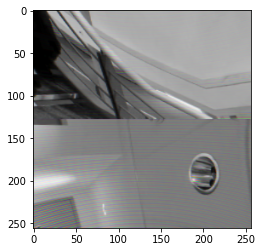

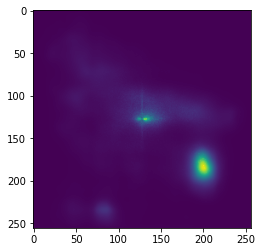

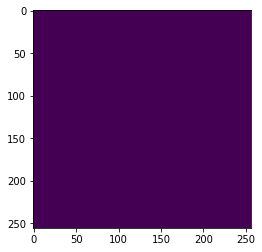

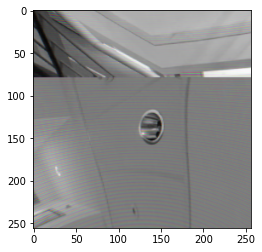

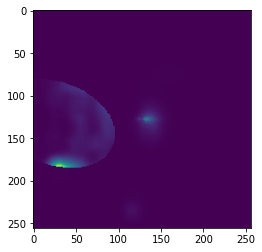

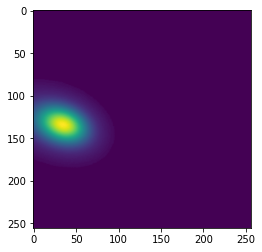

KeyboardInterrupt: 

In [134]:
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[255, 255, 255])
camera = pyrender.camera.PerspectiveCamera(np.deg2rad(70), znear=0.05, zfar=None, aspectRatio=1.)

fixed_height = 512
camera_offsets = (0, 0, 0)
# comment out when using actual gaze
# gaze_df = np.zeros((1, 2), dtype=np.float32)

# gaze_df[:, 0] = 0 # 0 is x (up down)
# gaze_df[:, 1] = 0 # 1 is y (left right)
vid_path = input_video_path
cap = cv2.VideoCapture(vid_path)
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# # make the output datastructure
# assert (gaze_df.ndim==2)
# if gaze_df.shape[0]>=frame_count:
#     gaze_df = gaze_df[:frame_count, ...]
# else:
#     gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

#  # set the first look-at-point
# gaze_df[0, 0] = starting_angle[0]
# gaze_df[0, 1] = starting_angle[1]

# set up simulation variables:
dt = 1/fps # time stamp
inhibition_map = np.zeros([height, width, 1])
d_inhibition_map = np.zeros([height, width, 1])
counter = 0
next_gaze_shift = 0 # track the time for the next gaze shift ()
next_head_shift = 0 # track the time for the next gaze shift ()
starting_angle = np.array(starting_angle)
current_gaze_target = starting_angle.copy()
current_gaze_pos = starting_angle.copy()
current_gaze_vel = np.array([0, 0])
current_head_target = starting_angle.copy()
current_head_vel = np.array([0, 0])
current_head_pos = starting_angle.copy()
sal = Salience_map_model()
for frame_num in tqdm(range(frame_count)):
    counter = frame_num # XD
    t = counter * dt
    ret, frame = cap.read()
    if not ret:
        break
    inhibition_map += d_inhibition_map * dt
    d_inhibition_map = np.where(inhibition_map < 0, 0, d_inhibition_map)
    inhibition_map = np.maximum(inhibition_map, 0)
    if t > next_gaze_shift:
        # update inhibition_map
        # ========================= render POV of scene =========================
        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=1000, inter=cv2.INTER_LANCZOS4)
        pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=frame_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)
        # get the rotation. 
        prev_fixation_point = [-current_gaze_target[1], current_gaze_target[0]]
        # compute the POV frame
        rotation = R.from_euler('xyz', [prev_fixation_point[0], -90-prev_fixation_point[1], 0], degrees=True)
        rot_mat = rotation.as_matrix()
        scale_mat = np.identity(3)
        rot_mat = np.matmul(scale_mat, rot_mat)
        cam_pose = np.identity(4)
        cam_pose[:3, :3] = rot_mat
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        color, depth = offscreen_renderer.render(scene)
        render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
        disp_frame = render.copy()
        # ==== get inhibition map render ====
        inhibition_map_RGB = cv2.cvtColor((np.minimum(inhibition_map, 1) * 255.0).astype('uint8'),cv2.COLOR_GRAY2RGB)
        inhibition_map_resized = (imutils.resize(inhibition_map_RGB, height=1000, inter=cv2.INTER_CUBIC))
        inhibition_map_pytexture, inhibition_map_pymaterial = get_texture(my_uvs=raw_uvs, img_array=inhibition_map_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=inhibition_map_pymaterial)
        # get the rotation
        try:
            scene.remove_node(pymesh_node)
            scene.remove_node(camera_node)
        except:
            pass
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        inhibition_map_color, inhibition_map_depth = offscreen_renderer.render(scene)
        inhibition_map_render = cv2.cvtColor(inhibition_map_color,cv2.COLOR_RGB2GRAY)
        disp_inhibition_map = inhibition_map_render.copy()
        # ============= get fixation point ==============
        fixation_point, salience_map = sal.get_fixation(disp_frame, bias_map, inhibition_map_render, 1)
        # plt.scatter([fixation_point[0]], [fixation_point[1]])
        # plt.scatter([50], [150])
        # plt.show()
        
        delta_horizontal_global = (fixation_point[0] - 128) / 256 * 70  # this is the delta horizontal in the global angle space (down positive)
        delta_vertical_global = (fixation_point[1] - 128) / 256 * 70    # this is the delta vertical in the global angle space (down positive)
        current_gaze_target[0] = current_gaze_target[0] + delta_horizontal_global # doing addtion between angles that are left positive
        current_gaze_target[1] = current_gaze_target[1] + delta_vertical_global # doing addtion between angles that are down positive
        # update inhibition map
        
        # find the index of the pixal on the global map 
        inhibition_point_index_vertical = current_gaze_target[1] / 180 * height + (height/2)
        inhibition_point_index_horizontal = current_gaze_target[0] / 360 * width + (width/2) 
        inhibition_point_index_vertical = math.floor(inhibition_point_index_vertical)
        inhibition_point_index_horizontal = math.floor(inhibition_point_index_horizontal)
        kernel = np.zeros_like(inhibition_map)
        kernel[inhibition_point_index_vertical, inhibition_point_index_horizontal] = 1
        inhibition_map_delta = gaussian_filter(kernel, sigma=5/360*width, mode='constant')
        inhibition_map_delta /= inhibition_map_delta.max()
        inhibition_map = inhibition_map + inhibition_map_delta
        # find the next time gaze shift should happen 
        gaze_duration = fixation_duration_sampler.rvs(1)[0]
        next_gaze_shift = t + gaze_duration + 0.08
        next_head_shift = t + T_h_sampler.rvs(1)[0]
        gaze_start = True
        d_inhibition_map -= inhibition_map_delta / np.minimum(gaze_duration * 20, (1.42 * 15))
        plt.imshow(render)
        plt.show()
        plt.imshow(salience_map)
        plt.show()
        plt.imshow(inhibition_map_render)
        plt.show()